# TGP TrES Data Analysis

Installing modules for notebook

In [1]:
#! pip install notebook --upgrade
#! pip list

#Dowmload Modules
#! pip install sep
#! pip install --no-deps ccdproc

In [2]:
import os
import numpy as np
from astropy.io import fits
from astropy.table import Table
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.ticker as mtick
import ccdproc as ccdp
from pathlib import Path as path
import sep
import re
from IPython.display import clear_output as clear
from datetime import datetime
import copy
from statistics import stdev

%matplotlib inline


## Opening and Viewing the Data

Funtion to open .fits files

In [3]:
def fits_plot(image_path='', image_data='', cmap='afmhot', title='', vmin=None, vmax=None, \
              xlim=(None, None), ylim=(None, None), dpi=80):
    """
    Plots the image of the FITS file and some useful information.

    Parameters
    ----------
    image_path : String
        File path of the image in .FITS format to plotted

    colour_map : String
        Desired colour map entry for use in plot
        To see more color maps:
        https://matplotlib.org/stable/tutorials/colors/colormaps.html

    Returns
    -------
    Image_plot(plt.imshow) : 

        Image of the FITS file
    """
    
    
    if title != '':
        plt.title(title)
    elif len(image_path) != 0:
        image_data = fits.getdata(image_path)
        plt.title(os.path.basename(image_path))
    
    plt.imshow(image_data, cmap=cmap, norm=Normalize(vmin=np.percentile(image_data, 35), \
               vmax=np.percentile(image_data, 95)), vmin=vmin, vmax=vmax)
    plt.gcf().set_dpi(dpi)
    plt.gca().invert_yaxis() #inverts y-axis into the right orientation
    plt.xlabel("x-pixels")
    plt.ylabel("y-pixels")
    plt.colorbar()
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.show()


In [4]:
def keyfunc(filename):
    a = re.compile("\D")
    return int(a.sub("", filename))

Collecting Files in directory and then plotting

In [5]:
dir = path("/storage/teaching/TelescopeGroupProject/2022-23/student-work/Exoplanets1/good")
data_files = ccdp.ImageFileCollection(dir)


#exoplanet TrES
exoplanet_files = sorted((data_files.files_filtered(include_path=True, imagetyp='Object', filter='V', object='TrES2b')), key = keyfunc)
exoplanet_files_names = sorted((data_files.files_filtered(imagetyp='Object', filter='V', object='TrES2b')), key = keyfunc)

#SA38
SA38_files = sorted((data_files.files_filtered(include_path=True, imagetyp='Object', filter='V', object='SA38')), key = keyfunc)
SA38_files_names = sorted((data_files.files_filtered(imagetyp='Object', filter='V', object='SA38')), key = keyfunc)


### Output image of the .fits file

Press enter for next image in input Textbook

# ***only run if images needed***
for image, image_name in zip(exoplanet_files, exoplanet_files_names):
    image_data = fits.getdata(image)
    fits_plot(image_data=image_data, title=str(image_name), dpi=500)
    
    text = input("")
    while text != "":
        text = input("")
    clear()

## Getting Light Curve Data

Finding the appropriate aperture size for Tres and, neighbouring stars 1, 2, 3. The fluxes are extracted and collected into a list. This is then dumped into a text file to save time having to run the images multiple times.

In [6]:
#in pixels
#tres_xy(2026.5, 1989.0)

# TrES
Tres_xlim = np.float64(np.array([2010.0, 2080.0]))
Tres_ylim = np.float64(np.array([1960.0, 2000.0]))

# Star 1 
Star1_xlim = np.float64(np.array([2275.0, 2350.0]))
Star1_ylim = np.float64(np.array([1775.0, 1815.0]))

# Star 2 
Star2_xlim = np.float64(np.array([2090.0, 2165.0]))
Star2_ylim = np.float64(np.array([2680.0, 2720.0]))

# Star 3
Star3_xlim = np.float64(np.array([750.0, 900.0]))
Star3_ylim = np.float64(np.array([1990.0, 2030.0]))

# Star 4
Star4_xlim = np.float64(np.array([3040.0, 3250.0]))
Star4_ylim = np.float64(np.array([3700.0, 3805.0]))

# Star 5
Star5_xlim = np.float64(np.array([1580.0, 1700.0]))
Star5_ylim = np.float64(np.array([1590.0, 1645.0]))

# Star 6
Star6_xlim = np.float64(np.array([2530.0, 2660.0]))
Star6_ylim = np.float64(np.array([2070.0, 2120.0]))

# Star 7
#Star7_xlim = np.float64(np.array([2280.0, 2470.0]))
#Star7_ylim = np.float64(np.array([3640.0, 3740.0]))

# Star 8
#Star8xlim = np.float64(np.array([2100.0, 2190.0]))
#Star8_ylim = np.float64(np.array([2355.0, 2400.0]))

In [7]:
def findFlux(files, xlim, ylim, bw=128, bh=128, fw=3, fh=3, aptR=17, DetThesh=10, checkBkg=False):
    objNo = 0
    fluxL = np.zeros((len(xlim), len(files)))
    fluxerrL = np.zeros((len(xlim), len(files)))
    print(np.shape(fluxL))

    for fileNo, image in enumerate(files):
        image_data = fits.open(image)
        
        data = image_data[0].data
        data = data.byteswap().newbyteorder()
        
        bkg = sep.Background(data, bw=bw, bh=bh, fw=fw, fh=fh)
        data -= bkg

        if checkBkg == True:
            bkg_image = bkg.back()
            plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
            plt.gcf().set_dpi(500)
            plt.colorbar()
            plt.show()

        objs = sep.extract(data, DetThesh, err=bkg.globalrms)
        flux, fluxerr, flag = sep.sum_circle(data, objs['x'], objs['y'], aptR, err=bkg.globalrms, gain=image_data[0].header['GAIN'])
        
        imgNo = 0
        for tar, x, y in zip(range(len(xlim)), xlim, ylim):
            for i in range(objs.size):
                if x[0] < objs['x'][i] < x[1] and y[0] < objs['y'][i] < y[1]:
                    print("{:.0f}: object {:d} {:f} {:f}: flux = {:f} ± {:f}".format(fileNo, i, objs['x'][i], objs['y'][i], flux[i], fluxerr[i]))
                    imgNo += 1
                    objNo += 1
                    fluxL[tar][fileNo] += flux[i]
                    fluxerrL[tar][fileNo] += fluxerr[i]
                    
                elif i >= len(objs):
                    print("Not found in image {:.0f}".format(fileNo))
                    
        print("{:.0f} found\n".format(imgNo))
        
    print("\nFound {:.0f} targets out of {:.0f} objects for all files.".format(objNo, len(exoplanet_files)*len(xlim)))
    
    return fluxL, fluxerrL

In [8]:
xlim = [
    Tres_xlim, 
    Star1_xlim, 
    Star2_xlim, 
    Star3_xlim, 
    Star4_xlim, 
    #Star5_xlim,
    #Star6_xlim,
]

ylim = [
    Tres_ylim, 
    Star1_ylim, 
    Star2_ylim, 
    Star3_ylim, 
    Star4_ylim, 
    #Star5_ylim,
    #Star6_ylim,
]

ALLfluxL, ALLfluxErrL = findFlux(exoplanet_files, xlim, ylim, bw=64, bh=64, fw=3, fh=3, aptR=14, DetThesh=40)

(5, 284)
0: object 57 2016.259098 1988.555055: flux = 109118.785636 ± 383.428769
0: object 49 2284.458462 1798.985274: flux = 52346.631002 ± 325.823563
0: object 74 2100.879738 2704.857598: flux = 190676.792784 ± 453.523479
0: object 60 755.106760 2018.873663: flux = 104271.204384 ± 378.841989
0: object 102 3100.653293 3756.397865: flux = 142336.630480 ± 413.376042
5 found

1: object 67 2016.450574 1988.113712: flux = 148122.812789 ± 423.822260
1: object 58 2284.511890 1798.548541: flux = 70717.492508 ± 352.041594
1: object 89 2101.166063 2704.507136: flux = 256165.954456 ± 507.286859
1: object 71 755.385444 2018.426867: flux = 138398.147446 ± 415.406715
1: object 123 3100.915978 3755.796988: flux = 190035.684035 ± 457.963994
5 found

2: object 56 2016.631040 1987.942362: flux = 110251.867343 ± 384.694507
2: object 48 2284.833778 1798.398940: flux = 52273.066577 ± 325.880684
2: object 73 2101.357224 2704.372001: flux = 190715.603789 ± 453.712624
2: object 59 755.653354 2018.276138: flu

23: object 55 2020.002138 1983.382312: flux = 110373.987239 ± 384.778851
23: object 47 2288.112028 1793.806785: flux = 52183.385730 ± 325.944951
23: object 72 2104.574355 2699.860535: flux = 191641.465971 ± 454.504266
23: object 58 758.877007 2013.687138: flux = 103055.930510 ± 377.934652
23: object 98 3104.409985 3751.511482: flux = 140774.158273 ± 412.279613
5 found

24: object 54 2019.431551 1984.189265: flux = 108887.471580 ± 383.679699
24: object 46 2287.703452 1794.677497: flux = 51955.783766 ± 326.038820
24: object 69 2104.380974 2700.263603: flux = 190954.039500 ± 454.192804
24: object 57 758.408326 2014.174194: flux = 103489.920439 ± 378.615065
24: object 94 3104.002274 3751.782046: flux = 141326.960704 ± 412.974422
5 found

25: object 55 2019.311285 1983.823500: flux = 109019.977048 ± 383.759092
25: object 47 2287.757179 1794.198290: flux = 52186.265088 ± 326.055115
25: object 72 2104.123908 2700.222112: flux = 191257.737860 ± 454.360914
25: object 58 758.942825 2014.044874: 

46: object 51 2015.667136 1986.236163: flux = 104466.157781 ± 381.739321
46: object 43 2283.770871 1796.710853: flux = 49215.733956 ± 325.540170
46: object 66 2100.175864 2702.555425: flux = 183313.882027 ± 449.893391
46: object 54 754.486365 2016.326501: flux = 98733.366924 ± 376.280282
46: object 92 3099.813235 3754.136927: flux = 134877.779123 ± 409.360815
5 found

47: object 50 2015.463114 1986.504082: flux = 105483.891555 ± 382.624226
47: object 42 2283.515718 1796.949024: flux = 49546.442121 ± 325.819780
47: object 65 2099.955698 2702.861719: flux = 184021.514295 ± 450.422349
47: object 53 754.353386 2016.676577: flux = 99145.540108 ± 376.606128
47: object 90 3099.679285 3754.619687: flux = 135809.639413 ± 410.122017
5 found

48: object 54 2016.250745 1986.521276: flux = 106307.212575 ± 383.248543
48: object 46 2284.435381 1797.083162: flux = 50482.736186 ± 326.691131
48: object 71 2100.859254 2702.924983: flux = 185344.863720 ± 451.366726
48: object 57 755.067264 2016.540144: fl

69: object 50 2019.512616 1987.634957: flux = 107545.944223 ± 383.922571
69: object 42 2287.627821 1798.172076: flux = 50971.687796 ± 326.524633
69: object 65 2104.108627 2704.118176: flux = 187463.216120 ± 452.618711
69: object 53 758.681097 2017.813688: flux = 101216.192372 ± 377.903337
69: object 88 3103.747982 3755.834220: flux = 138014.545356 ± 411.469687
5 found

70: object 45 2019.877674 1987.743718: flux = 107374.972027 ± 383.825957
70: object 37 2287.886631 1798.295604: flux = 51540.564545 ± 327.343438
70: object 60 2104.470135 2704.122037: flux = 186654.321938 ± 452.064619
70: object 48 758.490702 2017.580164: flux = 100731.136209 ± 377.548178
70: object 85 3104.346804 3756.144081: flux = 136888.372581 ± 410.521276
5 found

71: object 52 2020.345421 1988.231405: flux = 107644.523905 ± 384.041150
71: object 44 2288.468091 1798.712732: flux = 51343.001714 ± 327.103285
71: object 68 2104.941147 2704.671158: flux = 188154.580472 ± 453.215136
71: object 55 759.333637 2018.219039: 

91: object 54 2023.285546 1986.769876: flux = 108810.686587 ± 385.064666
91: object 46 2291.532582 1797.283221: flux = 51253.533001 ± 326.897886
91: object 72 2107.757936 2703.224007: flux = 190455.071774 ± 454.935503
91: object 57 762.223639 2016.678947: flux = 102370.175503 ± 379.012436
91: object 99 3107.264571 3754.869577: flux = 139909.670778 ± 413.068324
5 found

92: object 56 2023.684705 1987.230590: flux = 108533.022027 ± 384.774462
92: object 48 2291.926133 1797.781412: flux = 51910.769026 ± 327.556459
92: object 73 2108.160648 2703.624880: flux = 189400.690571 ± 454.075024
92: object 59 762.732942 2017.114797: flux = 103106.888501 ± 379.673856
92: object 102 3107.569721 3755.315614: flux = 140459.205336 ± 413.545480
5 found

93: object 57 2023.763906 1987.032128: flux = 107983.485392 ± 384.238358
93: object 49 2291.996081 1797.608158: flux = 52272.523922 ± 327.941530
93: object 75 2108.210997 2703.433226: flux = 190657.727166 ± 455.081092
93: object 60 762.836088 2016.935948:

113: object 60 2027.967782 1988.680287: flux = 109551.098612 ± 385.921417
113: object 52 2296.246704 1799.182131: flux = 52719.746716 ± 328.611833
113: object 78 2112.466392 2705.063196: flux = 191245.238847 ± 455.705089
113: object 63 767.006106 2018.477142: flux = 103912.946001 ± 380.576064
113: object 108 3111.875548 3756.923434: flux = 140978.436154 ± 414.130367
5 found

114: object 58 2027.938811 1988.503457: flux = 108607.585008 ± 385.151517
114: object 50 2296.263840 1799.049698: flux = 52922.982123 ± 329.005098
114: object 76 2112.479195 2704.884971: flux = 192019.959611 ± 456.419414
114: object 61 766.880098 2018.313899: flux = 102994.863744 ± 379.837345
114: object 105 3111.977348 3756.750910: flux = 140518.517982 ± 413.833502
5 found

115: object 57 2027.999498 1988.190933: flux = 109185.355398 ± 385.631893
115: object 49 2296.274677 1798.770023: flux = 52250.166538 ± 328.400967
115: object 75 2112.519253 2704.737063: flux = 192484.583191 ± 456.865560
115: object 60 766.9826

135: object 57 2031.404368 1991.294247: flux = 107521.658491 ± 384.589213
135: object 49 2299.561225 1801.843977: flux = 52226.063943 ± 328.855892
135: object 73 2115.761418 2707.613420: flux = 187294.916993 ± 453.069740
135: object 60 770.461908 2020.988275: flux = 102020.978314 ± 379.427585
135: object 101 3115.153893 3759.671851: flux = 138692.852702 ± 412.748942
5 found

136: object 56 2031.780305 1990.645053: flux = 107251.025284 ± 384.352533
136: object 48 2299.929053 1801.244590: flux = 52589.665950 ± 329.314459
136: object 74 2116.026839 2706.949062: flux = 189196.525440 ± 454.656541
136: object 59 770.684765 2020.372196: flux = 103052.055861 ± 380.468759
136: object 101 3115.478906 3758.937267: flux = 139147.598353 ± 413.188205
5 found

137: object 55 2031.592581 1990.685647: flux = 107428.226570 ± 384.522594
137: object 47 2299.657795 1801.357592: flux = 51876.850589 ± 328.504992
137: object 72 2115.921536 2707.012122: flux = 189208.884481 ± 454.644697
137: object 58 770.5206

157: object 55 2034.078972 1989.464137: flux = 107265.294651 ± 384.997997
157: object 47 2302.323687 1800.020507: flux = 52040.899853 ± 329.376778
157: object 72 2118.385906 2705.835507: flux = 189193.008354 ± 455.087097
157: object 58 773.043894 2019.193959: flux = 102123.771626 ± 380.084895
157: object 100 3117.524754 3757.804814: flux = 139138.176425 ± 413.701551
5 found

158: object 57 2034.189240 1989.412076: flux = 107689.385918 ± 385.070703
158: object 49 2302.404453 1799.996258: flux = 52048.939429 ± 328.951255
158: object 75 2118.558306 2705.821642: flux = 189278.579328 ± 454.957044
158: object 60 773.039746 2019.119166: flux = 102938.882320 ± 380.691803
158: object 102 3117.727714 3757.884288: flux = 139365.434943 ± 413.670397
5 found

159: object 57 2034.167224 1989.118538: flux = 107555.604874 ± 385.190228
159: object 49 2302.519479 1799.724806: flux = 51711.916378 ± 328.889858
159: object 74 2118.545913 2705.462046: flux = 187941.793928 ± 454.050455
159: object 60 773.1615

179: object 54 2036.518783 1987.776574: flux = 107205.904325 ± 385.428533
179: object 46 2304.720675 1798.398493: flux = 51887.978552 ± 329.742703
179: object 71 2120.787107 2704.254632: flux = 188077.374819 ± 454.667076
179: object 57 775.529919 2017.431474: flux = 102106.600359 ± 380.645805
179: object 99 3120.072870 3756.380286: flux = 136970.373606 ± 412.261037
5 found

180: object 54 2036.871583 1988.061019: flux = 107080.886634 ± 385.204142
180: object 46 2305.012264 1798.716704: flux = 51356.130983 ± 329.057103
180: object 71 2121.136509 2704.625304: flux = 189714.701588 ± 455.889957
180: object 57 775.863515 2017.713389: flux = 100671.770743 ± 379.196377
180: object 99 3120.327540 3756.683197: flux = 138641.484766 ± 413.627486
5 found

181: object 53 2037.204850 1987.510838: flux = 105971.071671 ± 384.134270
181: object 45 2305.380627 1798.111250: flux = 51436.868892 ± 329.150116
181: object 71 2121.539090 2703.945831: flux = 188067.932943 ± 454.551420
181: object 56 776.135914

201: object 54 2040.163633 1987.217744: flux = 107699.150237 ± 386.412046
201: object 46 2308.525341 1797.758112: flux = 51666.420433 ± 330.254924
201: object 70 2124.515050 2703.613239: flux = 189136.322679 ± 455.993613
201: object 57 779.284804 2016.718232: flux = 101534.753013 ± 380.673262
201: object 97 3123.672127 3755.694431: flux = 138339.044370 ± 414.004079
5 found

202: object 52 2040.581693 1986.698281: flux = 106121.645955 ± 384.983547
202: object 44 2308.908367 1797.254734: flux = 51174.131542 ± 329.662068
202: object 69 2124.963491 2703.135717: flux = 187886.407769 ± 454.991467
202: object 55 779.702752 2016.150909: flux = 101006.278486 ± 380.180060
202: object 97 3124.154408 3755.304767: flux = 137410.342049 ± 413.202353
5 found

203: object 56 2040.747761 1986.640036: flux = 106689.580789 ± 385.440431
203: object 48 2309.049042 1797.259449: flux = 51378.797722 ± 329.764180
203: object 74 2125.037979 2702.927348: flux = 188888.079712 ± 455.746202
203: object 59 779.683308

223: object 106 2049.105529 1983.755499: flux = 439806.108465 ± 692.749669
223: object 95 2317.308010 1794.380155: flux = 216128.684855 ± 564.748289
223: object 145 2133.239512 2700.234990: flux = 771421.558982 ± 847.566052
223: object 111 788.131244 2013.184323: flux = 419682.203000 ± 682.189131
223: object 200 3132.236084 3752.444842: flux = 571465.610736 ± 757.988693
5 found

224: object 106 2049.999018 1983.385623: flux = 439758.206061 ± 692.892611
224: object 95 2318.158577 1794.056362: flux = 215836.798563 ± 564.956571
224: object 146 2134.097440 2699.859243: flux = 774402.114341 ± 849.129836
224: object 111 789.006232 2012.780665: flux = 417695.497640 ± 681.366017
224: object 202 3133.043567 3752.056032: flux = 570215.363753 ± 757.688990
5 found

225: object 105 2050.167847 1983.184438: flux = 441970.761476 ± 694.014361
225: object 94 2318.366702 1793.784573: flux = 215008.849748 ± 564.246385
225: object 145 2134.307894 2699.681819: flux = 771618.264635 ± 847.884521
225: object 

245: object 91 2059.251009 1977.073288: flux = 439265.651157 ± 696.546786
245: object 80 2327.472729 1787.706950: flux = 213293.458412 ± 567.985477
245: object 127 2143.365891 2693.537293: flux = 762584.573550 ± 847.264942
245: object 95 798.027032 2006.133767: flux = 413009.931895 ± 682.885327
245: object 176 3142.090423 3745.868194: flux = 563793.334910 ± 758.176506
5 found

246: object 98 2059.823513 1976.272725: flux = 438020.748544 ± 696.292088
246: object 87 2328.039379 1786.929423: flux = 212817.379324 ± 568.169764
246: object 134 2143.877255 2692.721775: flux = 761026.575882 ± 846.851157
246: object 102 798.917932 2005.494303: flux = 413162.132494 ± 683.296928
246: object 185 3142.601371 3745.121700: flux = 561956.701049 ± 757.567213
5 found

247: object 93 2059.834334 1976.321893: flux = 438693.308650 ± 696.485847
247: object 82 2328.123193 1786.983663: flux = 212865.555083 ± 567.924734
247: object 128 2144.009579 2692.821050: flux = 761544.163055 ± 846.860255
247: object 97 7

267: object 95 2067.243604 1970.816941: flux = 436788.672159 ± 699.073107
267: object 84 2335.519425 1781.472485: flux = 212291.914839 ± 572.108500
267: object 130 2151.270556 2687.312512: flux = 755985.160625 ± 847.616869
267: object 99 806.482407 1999.751912: flux = 411201.975707 ± 685.904944
267: object 179 3149.934103 3739.801694: flux = 560404.536412 ± 760.038264
5 found

268: object 93 2067.554719 1970.008281: flux = 437198.482643 ± 699.369343
268: object 82 2335.808899 1780.716807: flux = 210888.016511 ± 571.290006
268: object 129 2151.577180 2686.566828: flux = 755018.713263 ± 847.190112
268: object 97 806.823160 1999.067067: flux = 411562.364405 ± 686.139702
268: object 179 3150.086224 3739.021978: flux = 562273.921650 ± 761.045714
5 found

269: object 90 2067.620098 1970.312705: flux = 437908.062509 ± 699.416141
269: object 79 2335.955730 1780.963011: flux = 211409.657350 ± 571.149562
269: object 125 2151.624639 2686.768021: flux = 757763.503761 ± 848.032445
269: object 94 80

In [8]:
exptimeL = np.zeros(len(exoplanet_files))

for i, image in enumerate(exoplanet_files):
    image_data = fits.open(image)
    exptimeL[i] += image_data[0].header['EXPTIME']
    
ALLfluxL /= exptimeL
ALLfluxErrL /= exptimeL

NameError: name 'ALLfluxL' is not defined

In [35]:
allList = {
    'Tres_fluxL': ALLfluxL[0],
    'Star1_fluxL': ALLfluxL[1],
    'Star2_fluxL': ALLfluxL[2],
    'Star3_fluxL': ALLfluxL[3],
    'Star4_fluxL': ALLfluxL[4],
    #'Star5_fluxL': ALLfluxL[5],
    #'Star6_fluxL': ALLfluxL[0],
}

allErrList = {
    'Tres_fluxLErr': ALLfluxErrL[0],
    'Star1_fluxLErr': ALLfluxErrL[1],
    'Star2_fluxLErr': ALLfluxErrL[2],
    'Star3_fluxLErr': ALLfluxErrL[3],
    'Star4_fluxLErr': ALLfluxErrL[4],
    #'Star5_fluxLErr': ALLfluxErrL[5],
    #'Star6_fluxLErr': ALLfluxErrL[0],
}

In [36]:
for fluxL, fluxErrL in zip(allList, allErrList):
    np.save(fluxL+'.npy', allList[fluxL])
    np.save(fluxErrL+'.npy', allErrList[fluxErrL])

## Obtaining data from saved file

In [60]:
allList = {
    'Tres_fluxL': [],
    'Star1_fluxL': [],
    'Star2_fluxL': [],
    'Star3_fluxL': [],
    'Star4_fluxL': [],
    #'Star5_fluxL': [],
    #'Star6_fluxL': []
}

allErrList = {
    'Tres_fluxLErr': [],
    'Star1_fluxLErr': [],
    'Star2_fluxLErr': [],
    'Star3_fluxLErr': [],
    'Star4_fluxLErr': [],
    #'Star5_fluxLErr': [],
    #'Star6_fluxLErr': []
}

In [61]:
for fluxL, fluxErrL in zip(allList, allErrList):
    allList[fluxL] = np.load(fluxL+'.npy')
    allErrList[fluxErrL] = np.load(fluxErrL+'.npy')

allList = list(allList.values())
allErrList = list(allErrList.values())

In [79]:
dateL = []
for i, image in enumerate(exoplanet_files):
    image_data = fits.open(image)
    t = image_data[0].header['DATE-OBS'].split("T")
    d = t[0].split("-")
    t = t[-1].split(":")
    s = t[-1].split(".")

    dateL += [datetime(int(d[0]), int(d[1]), int(d[2]), int(t[0]), int(t[1]), int(s[0]), int(s[1][:-1]))]

dateL = np.array(mdates.date2num(dateL), dtype=float)

In [80]:
dateL -= dateL[0]
np.save('DateL.npy', dateL)
dateL -= dateL[175] #dateL[int(len(dateL)/2)]
dateL *= 24

#dateL = mdates.num2date(mdates.date2num(dateL) - mdates.date2num(dateL[0]))
#dateL = mdates.num2date(mdates.date2num(dateL) - mdates.date2num(dateL[int(len(dateL)/2)]))

In [78]:
dateL[175]

0.04911340483522508

#### Correnting flux data with exposure time and mean for relative flux

exptimeL = np.zeros(len(exoplanet_files))
#relFluxL = np.zeros(len(fluxL))

for i, image in enumerate(exoplanet_files):
    image_data = fits.open(image)
    exptimeL[i] = image_data[0].header['EXPTIME']

for fluxL in allList:
    fluxL /= exptimeL

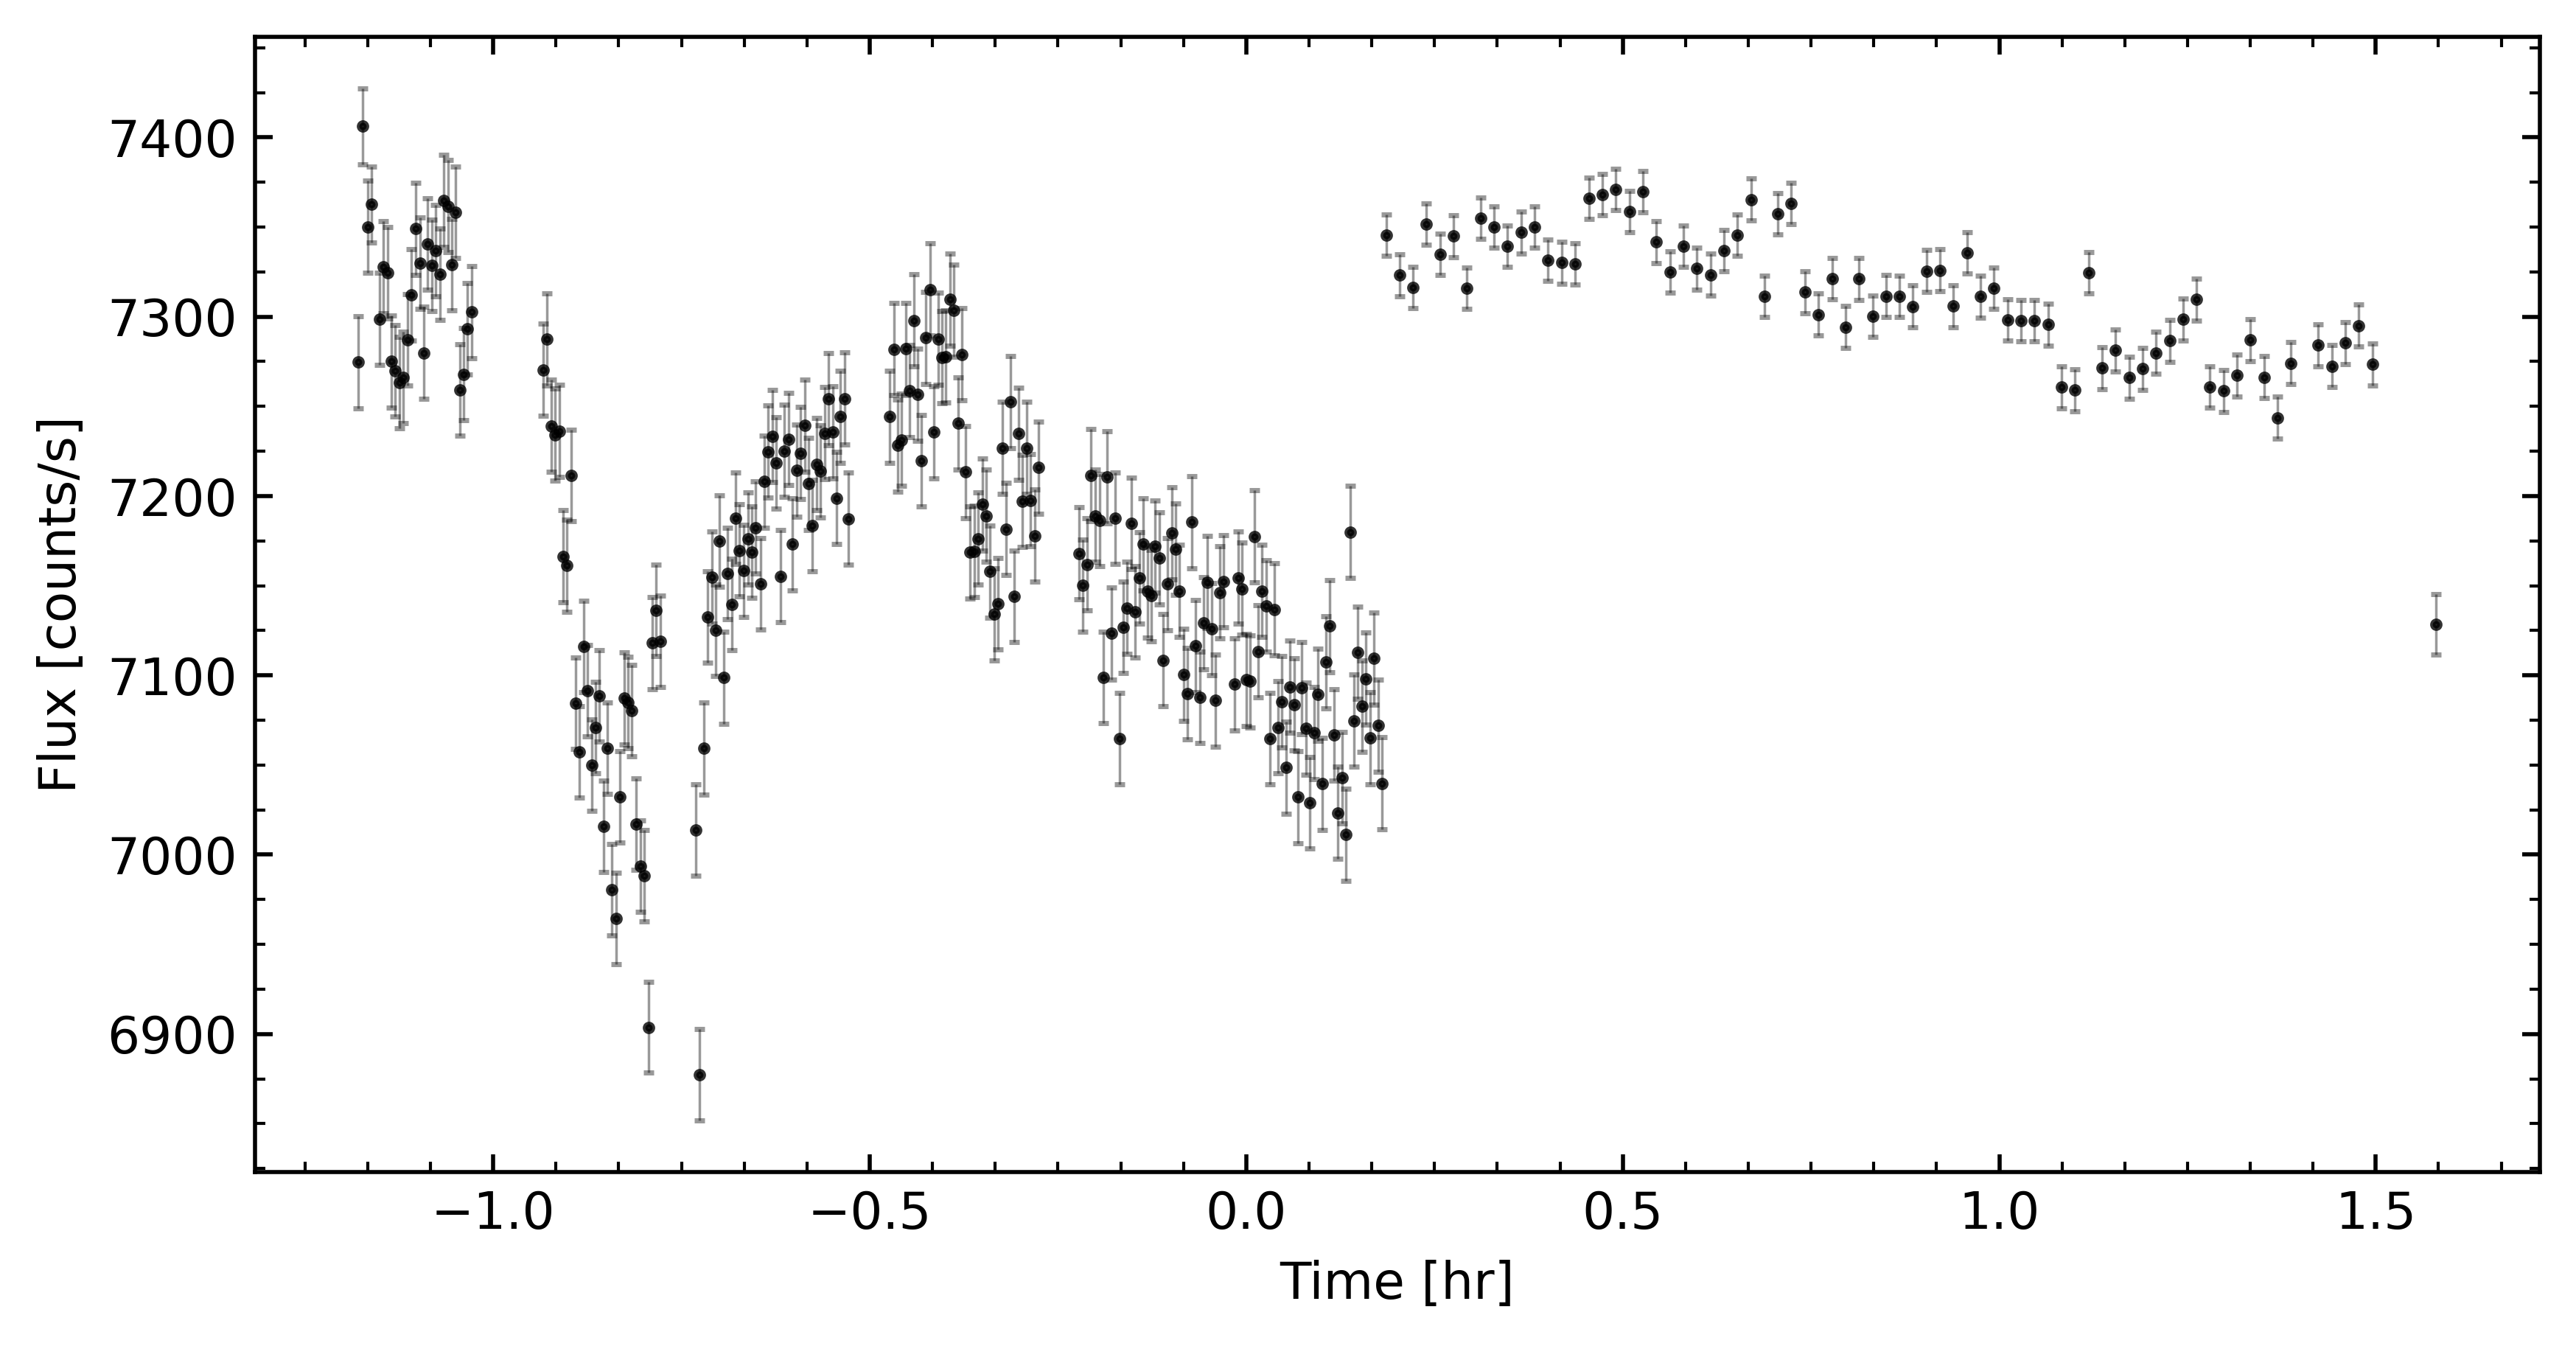

In [65]:
plt.figure(figsize=(8,4), dpi=500)
#plt.grid()
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H.%M hr'))
plt.scatter(dateL, allList[0], s=2, color='black', alpha=0.8)
plt.errorbar(dateL, allList[0], yerr=allErrList[0], ecolor='black', elinewidth=0.5, alpha=0.4, capsize=1, 
                linewidth=0)

plt.gca().tick_params(top=True, right=True, which='both', direction="in")
plt.gca().xaxis.set_minor_locator(mtick.AutoMinorLocator(6))
plt.gca().yaxis.set_minor_locator(mtick.AutoMinorLocator(4))
plt.xlabel("Time [hr]")
plt.ylabel("Flux [counts/s]")
plt.show()
#plt.savefig('N2_Lightcurve.png')

In [30]:
def relMaxFlux(fluxL):
    relFluxL = []
    
    for flux in fluxL:
        relFluxL += [(flux/np.max(fluxL))*100]
        
    return relFluxL

In [31]:
def normFlux(fluxL):
    relFluxL = []
    #for i in range(len(fluxL)):
    relFluxL += [((fluxL-np.min(fluxL))/(np.max(fluxL)-np.min(fluxL)))*100]

    return relFluxL

In [32]:
def fluxBin(x, y, bins, c=0):
    avg_y = []
    avg_x = []
    avgErr_y = []

    if len(y) != len(x):
        raise ValueError("The lenght of lists are not equal.")
    else:
        for i in range(len(y)//bins):
            avg_y += [np.mean(y[c:c+bins])]
            avg_x += [np.mean(x[c:c+bins])] #mdates.num2date(np.mean(mdates.date2num(
            
            avgErr_y += [stdev(y[c:c+bins])]
            c += bins
            
    return avg_x, avg_y, avgErr_y

In [33]:
start = 2
end = 4

colorl = ['rebeccapurple', 'darkorange', 'green', 'royalblue', 'crimson']

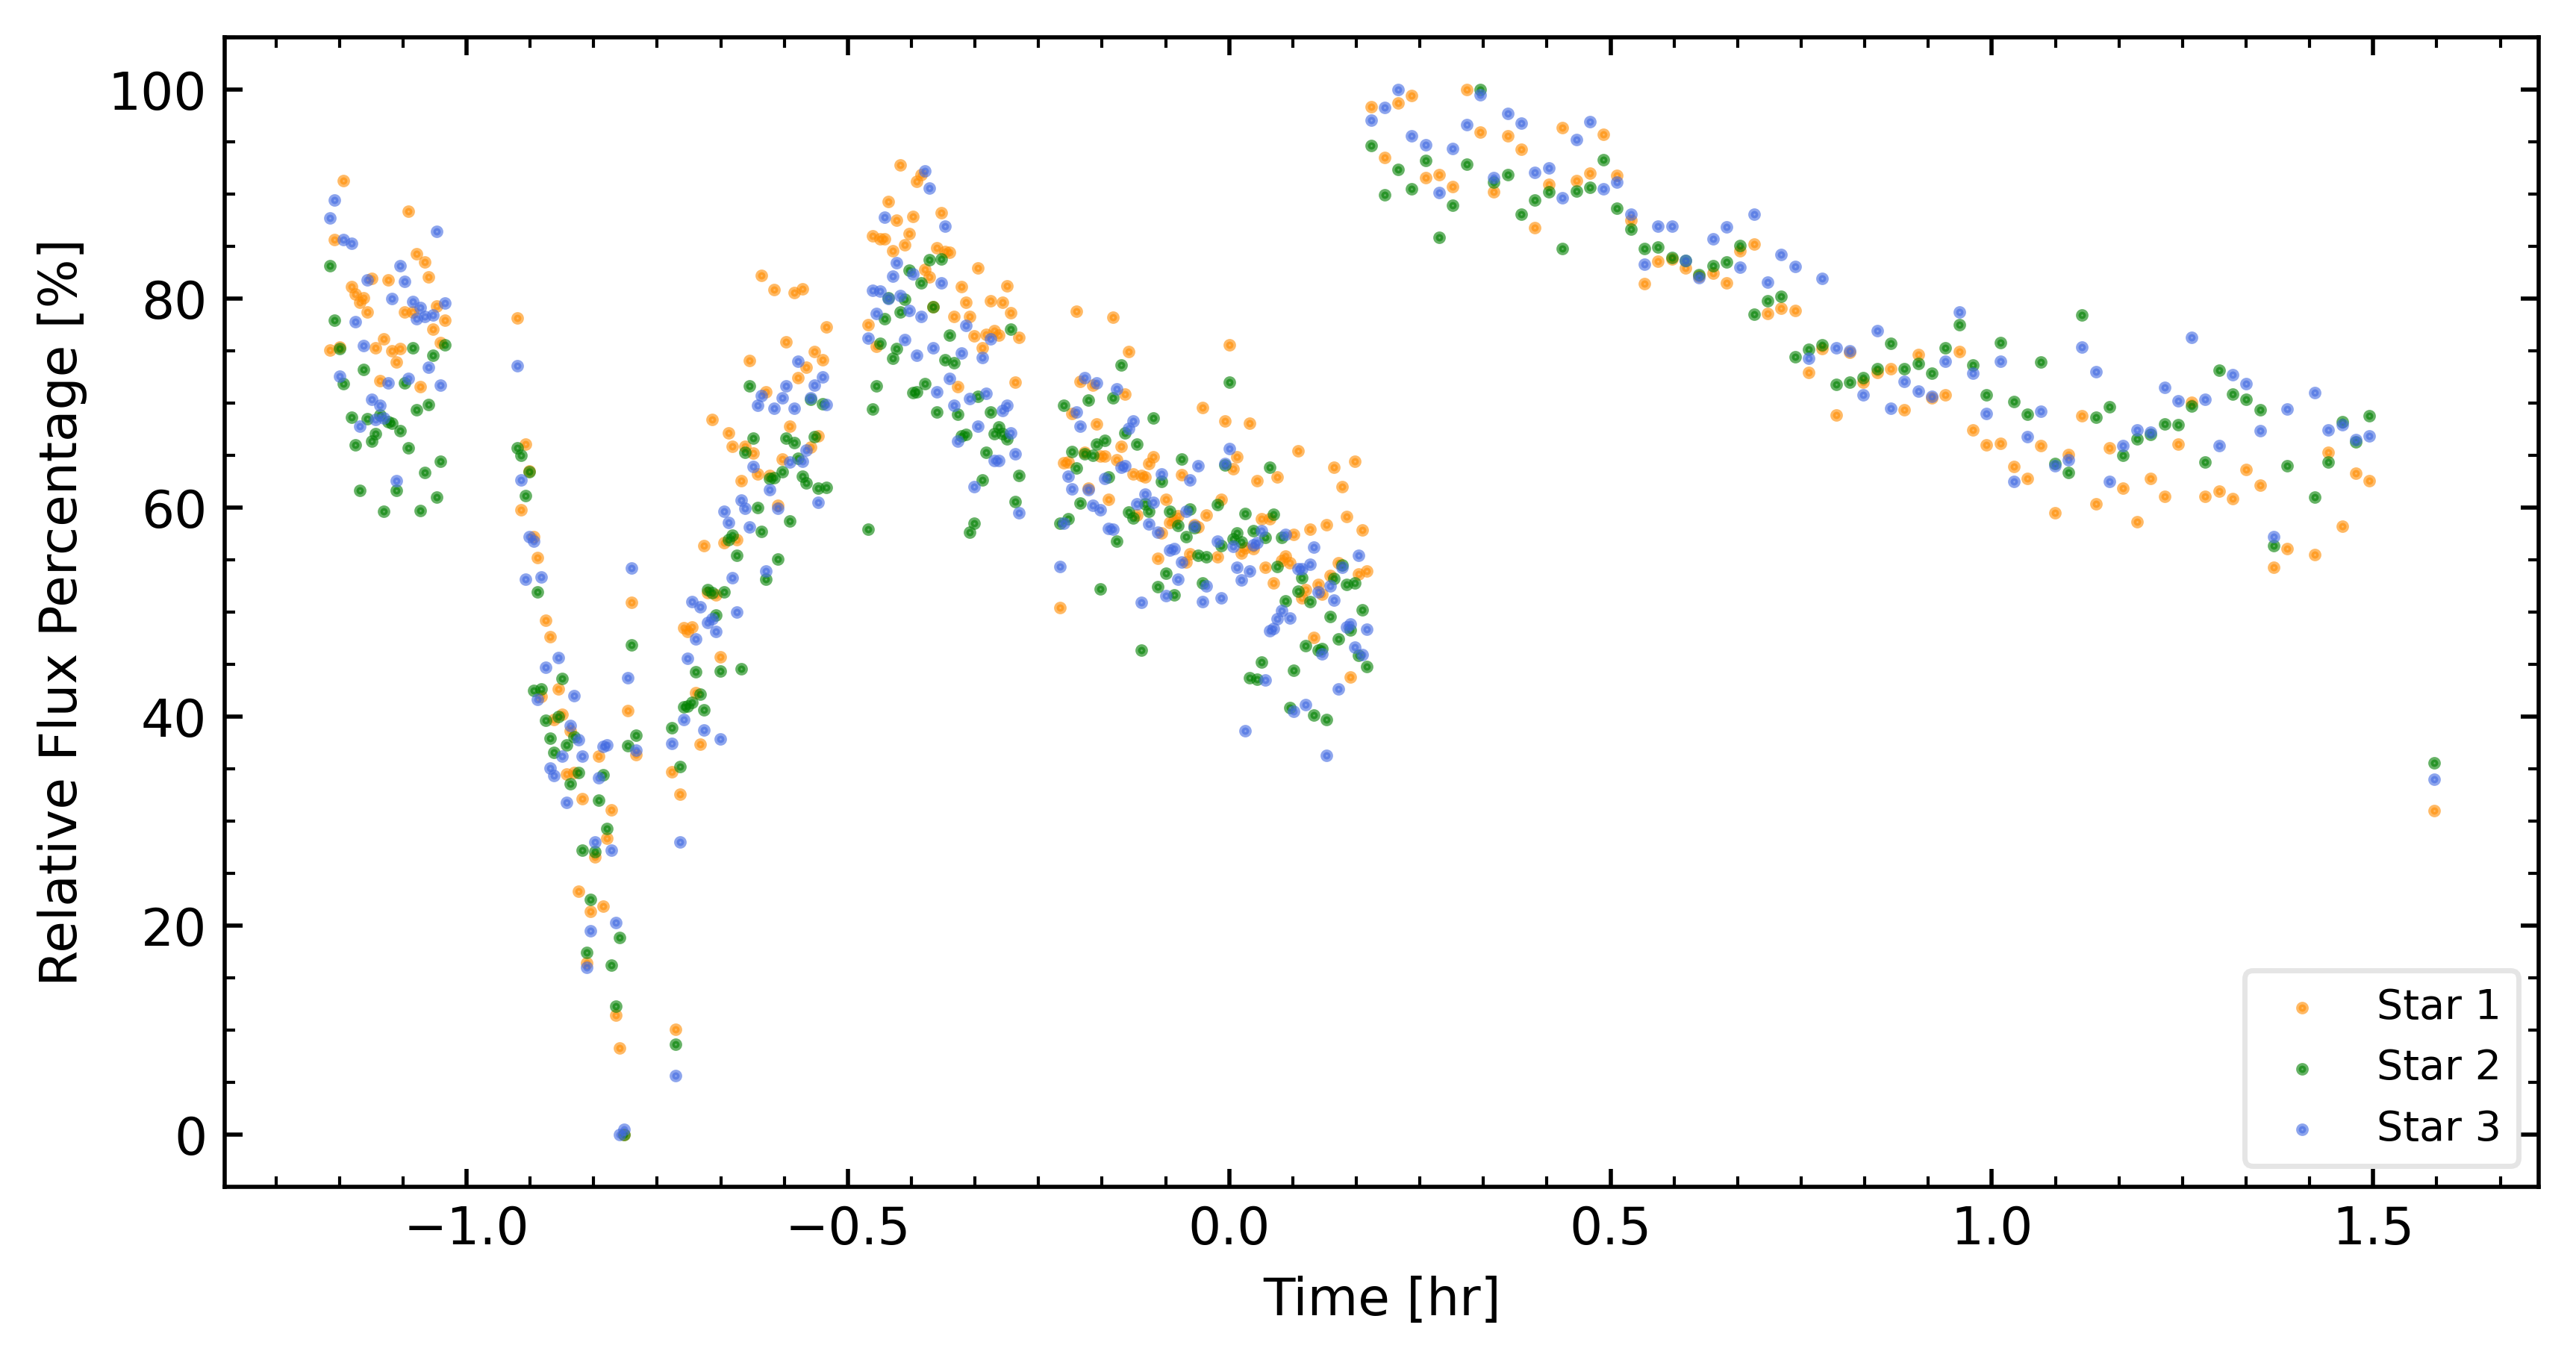

In [34]:
plt.figure(figsize=(8,4), dpi=500)

#plt.scatter(dateL, normFlux(allList[0]), s=3, color='black', alpha=0.6, label='TrES')
for i in range(start,end+1):
    plt.scatter(dateL, normFlux(allList[i]), s=2, color=colorl[i-1], alpha=0.6, label='Star '+str(i-start+1))

plt.gca().tick_params(top=True, right=True, which='both', direction="in")
plt.gca().xaxis.set_minor_locator(mtick.AutoMinorLocator(6))
plt.gca().yaxis.set_minor_locator(mtick.AutoMinorLocator(4))
plt.xlabel("Time [hr]")
plt.ylabel("Relative Flux Percentage [%]")
plt.legend(loc=4, framealpha=0.5, fontsize=8)
plt.show()

In [35]:
fluxL = allList[0]
avg = np.average(allList[start:end+1], axis=0)

fluxL /= avg

flavg = []
for flux in fluxL:
    if (np.max(fluxL)*0.988) < flux < (np.max(fluxL)*0.999):
        flavg += [flux]
        
fluxL /= np.average(flavg)

In [36]:
starL = []

for i in range(start,end+1):
    starList = allList[i]
    starList /= avg
    starList /= np.average(starList) #normalising
    starL += [starList]

To fliter max of the TrES flux list (Outlier)

In [37]:
"""fluxLL = []
dateLL = []

for flux, date in zip(fluxL, dateL):
    if flux != max(fluxL):
        dateLL += [date]
        fluxLL += [flux]
        
fluxL = fluxL
dateL = dateLL"""

'fluxLL = []\ndateLL = []\n\nfor flux, date in zip(fluxL, dateL):\n    if flux != max(fluxL):\n        dateLL += [date]\n        fluxLL += [flux]\n        \nfluxL = fluxL\ndateL = dateLL'

In [38]:
# 3,1 or 4,0, or 5,3
bins = 6
c = 0

In [39]:
avgD, avgResd, avgErr = fluxBin(dateL, np.average(starL, axis=0)-1, bins, c=c)

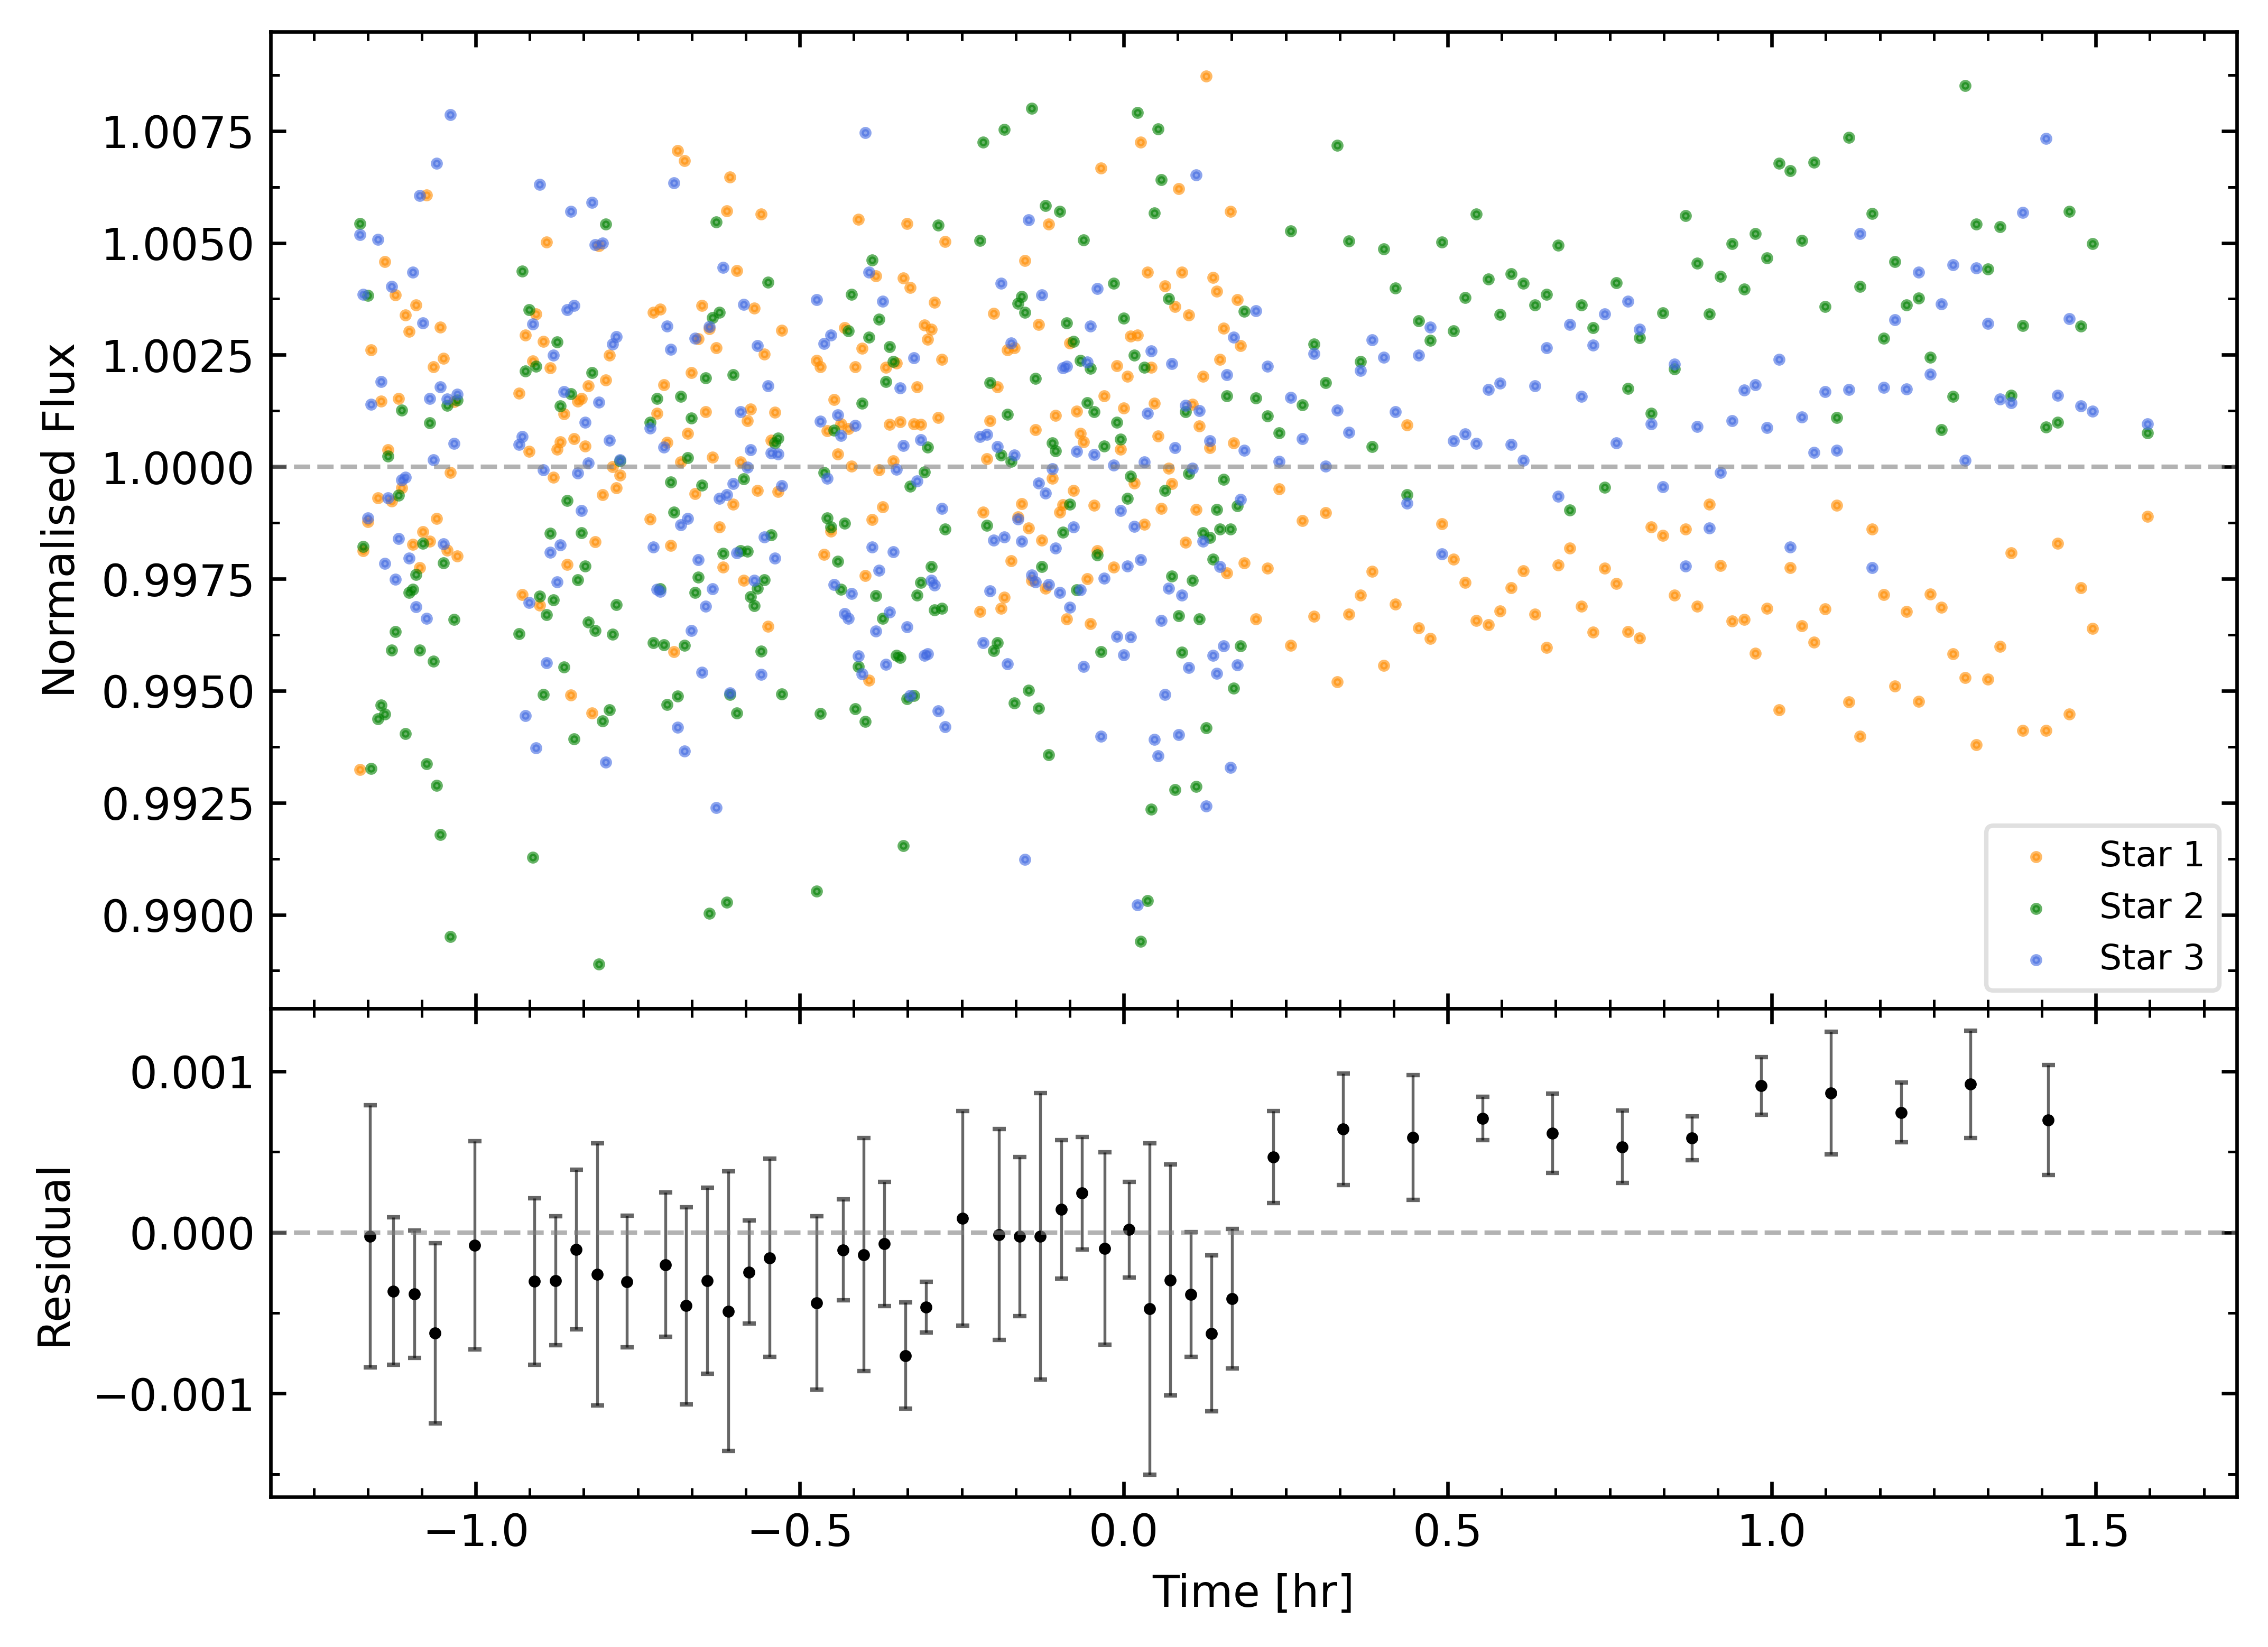

In [40]:
fig = plt.figure(figsize=(8,6), dpi=600)
gs = fig.add_gridspec(2, hspace=0, height_ratios=[2,1])
axs = gs.subplots(sharex=True)

# Plot1
for i, starList, col in zip(range(start, end+1), starL, colorl[start-1:end]):
    axs[0].scatter(dateL, starList, s=3, color=col, alpha=0.6, label=str('Star '+str(i-start+1)))

axs[0].tick_params(top=True, right=True, which='both')
axs[0].axhline(y=1, color='grey', linestyle = '--', alpha=0.6, linewidth=1)
axs[0].legend(framealpha=0.6, fontsize=8)
axs[0].set(ylabel="Normalised Flux")
axs[0].tick_params(which="both", axis="x", direction="in")
axs[0].tick_params(which="both", axis="y", direction="in")
axs[0].yaxis.set_minor_locator(mtick.AutoMinorLocator(2))



# Plot2
axs[1].scatter(avgD, avgResd, s=3, color='black')
axs[1].errorbar(avgD, avgResd, yerr=avgErr, ecolor='black', elinewidth=0.65, alpha=0.6, capsize=1.5, linewidth=0)

axs[1].tick_params(top=True, right=True, which='both')
axs[1].axhline(y=0, color='grey', linestyle = '--', alpha=0.6, linewidth=1)
axs[1].set(ylabel="Residual")
axs[1].tick_params(which="both", axis="x", direction="in")
axs[1].tick_params(which="both", axis="y", direction="in")
axs[1].yaxis.set_minor_locator(mtick.AutoMinorLocator(2))


plt.gca().xaxis.set_minor_locator(mtick.AutoMinorLocator(6))
plt.xlabel("Time [hr]")
plt.show()

In [41]:
#print(fluxErrL/500)

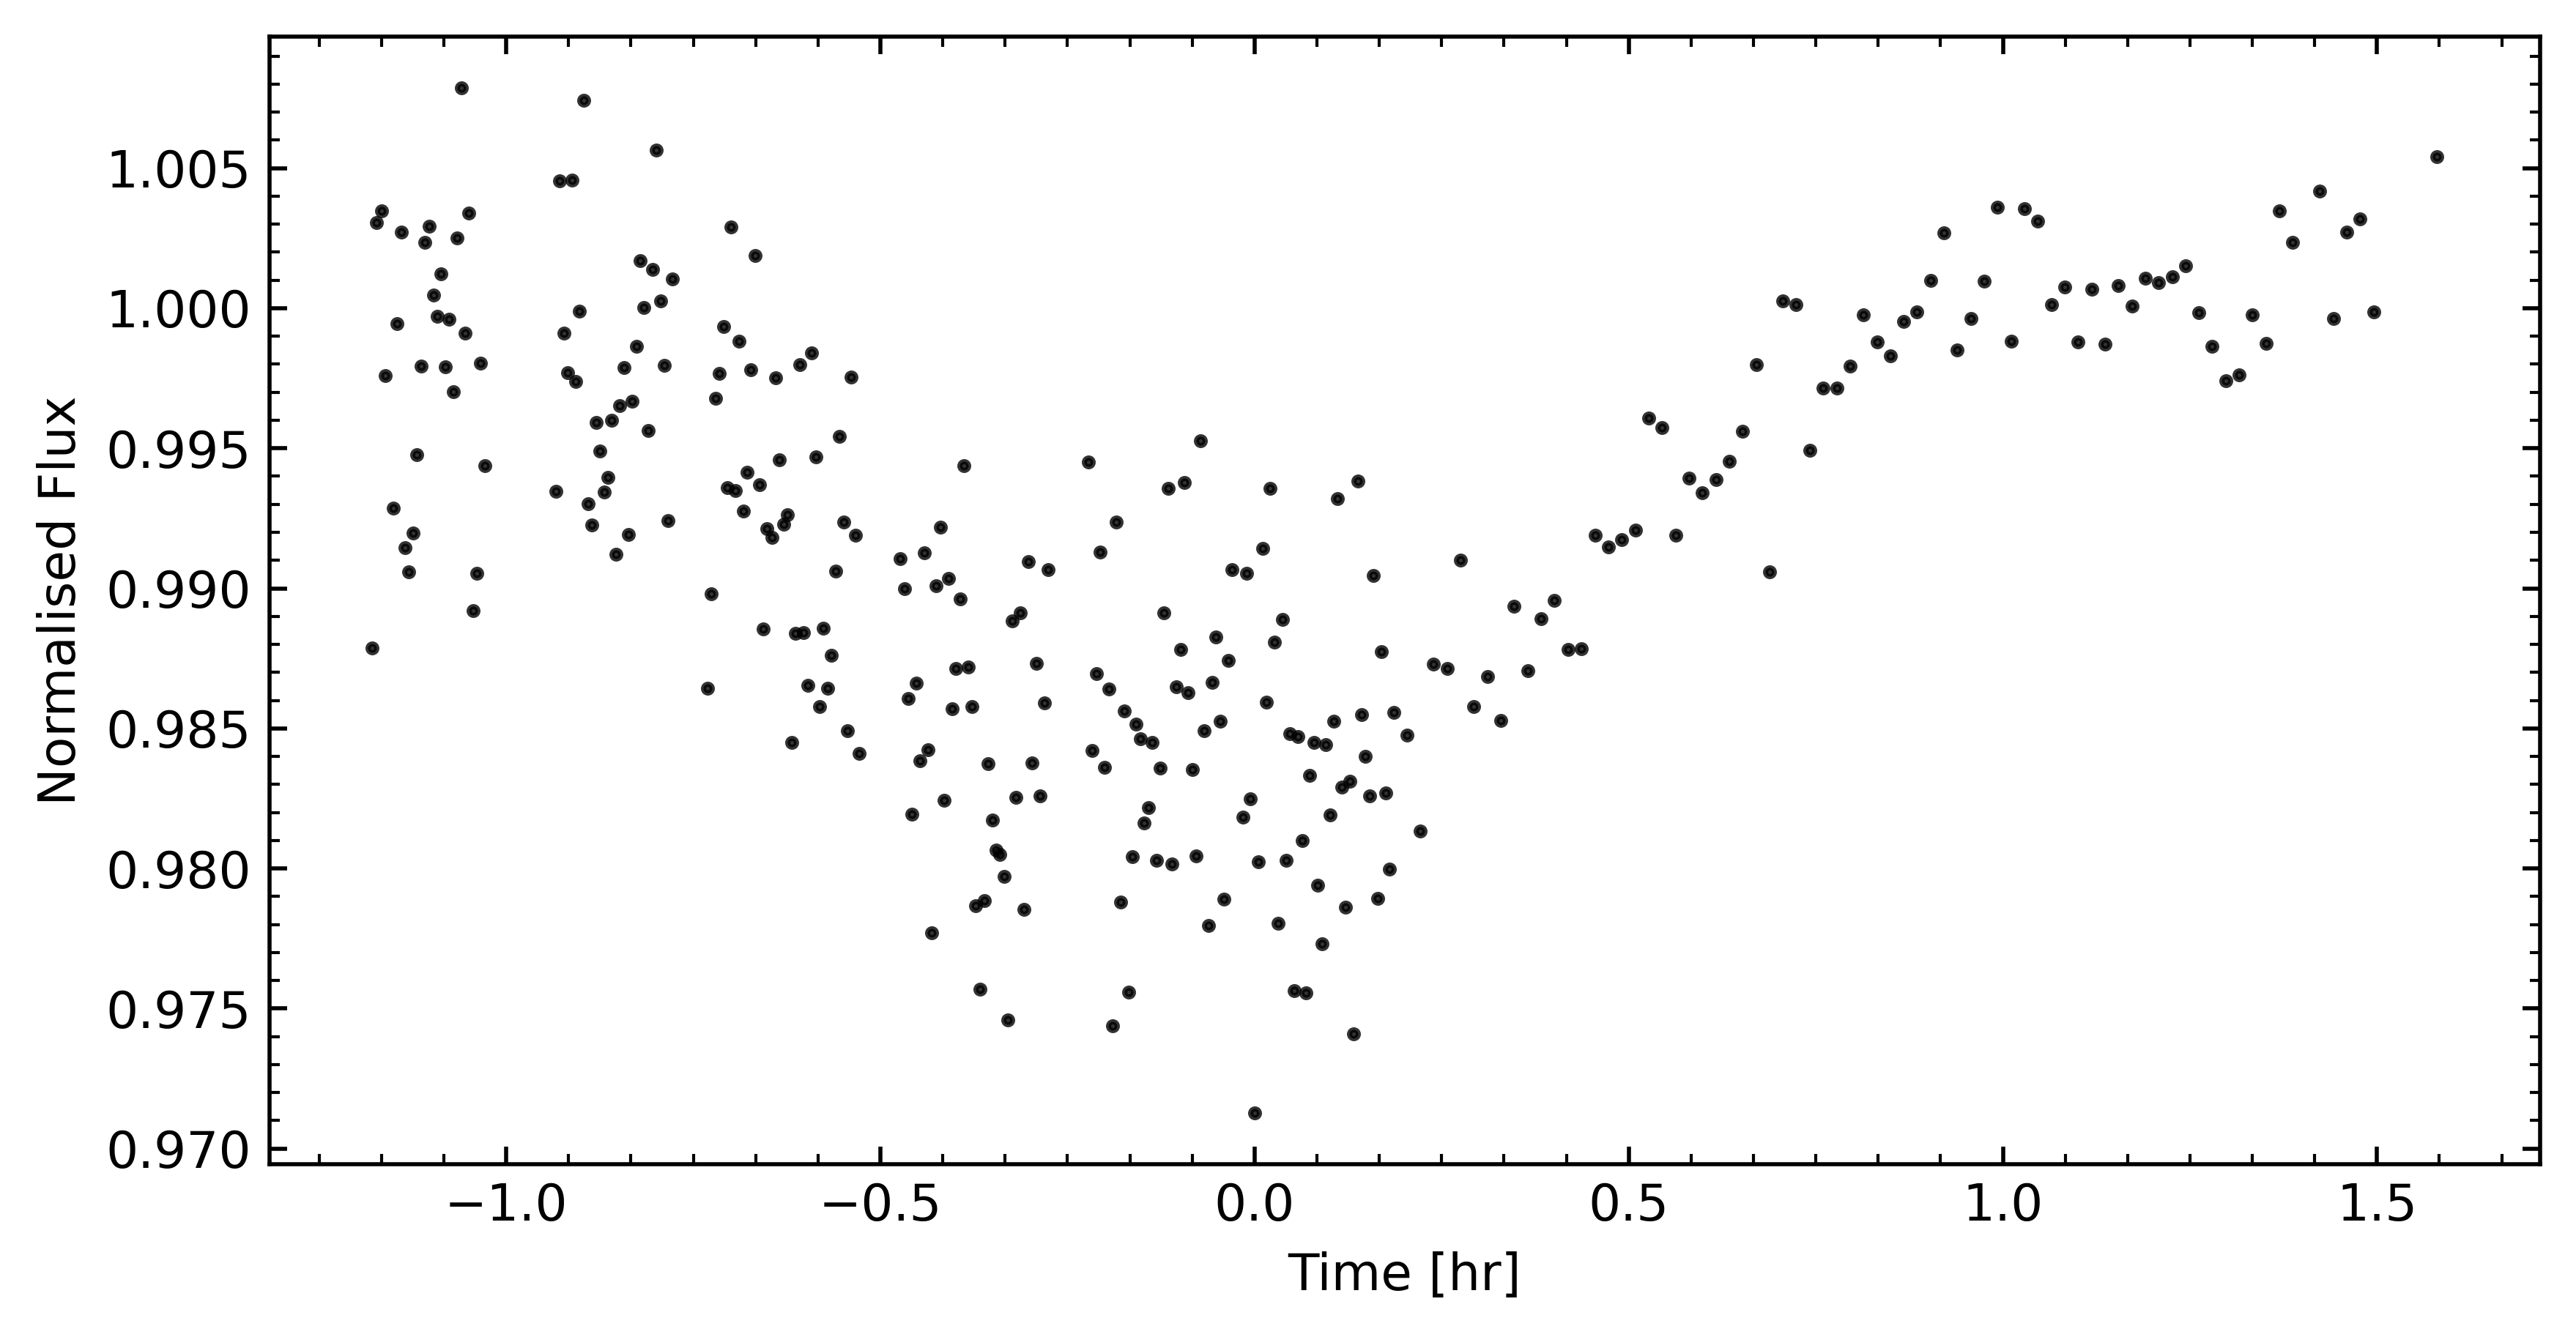

In [44]:
plt.figure(figsize=(8,4), dpi=500)
plt.scatter(dateL, fluxL, s=3, color='black', alpha=0.8)
#plt.errorbar(dateL, fluxL, yerr=fluxErrL, ecolor='black', elinewidth=0.5, alpha=0.4, capsize=1, 
#             linewidth=0)
plt.gca().tick_params(top=True, right=True, which='both', direction="in")
plt.gca().xaxis.set_minor_locator(mtick.AutoMinorLocator(6))
plt.gca().yaxis.set_minor_locator(mtick.AutoMinorLocator(5))
plt.xlabel("Time [hr]")
plt.ylabel("Normalised Flux")
plt.show()

In [45]:
min_f = fluxL[0]
mini = 0
for i, flux in enumerate(fluxL):
    if flux < min_f:
        min_f = flux
        mini = i

print(mini, min_f)

175 0.9712757293664559


### Errors and Bins

In [46]:
avgDate, avgFlux, avgFluxErr = fluxBin(dateL, fluxL, bins, c=c)

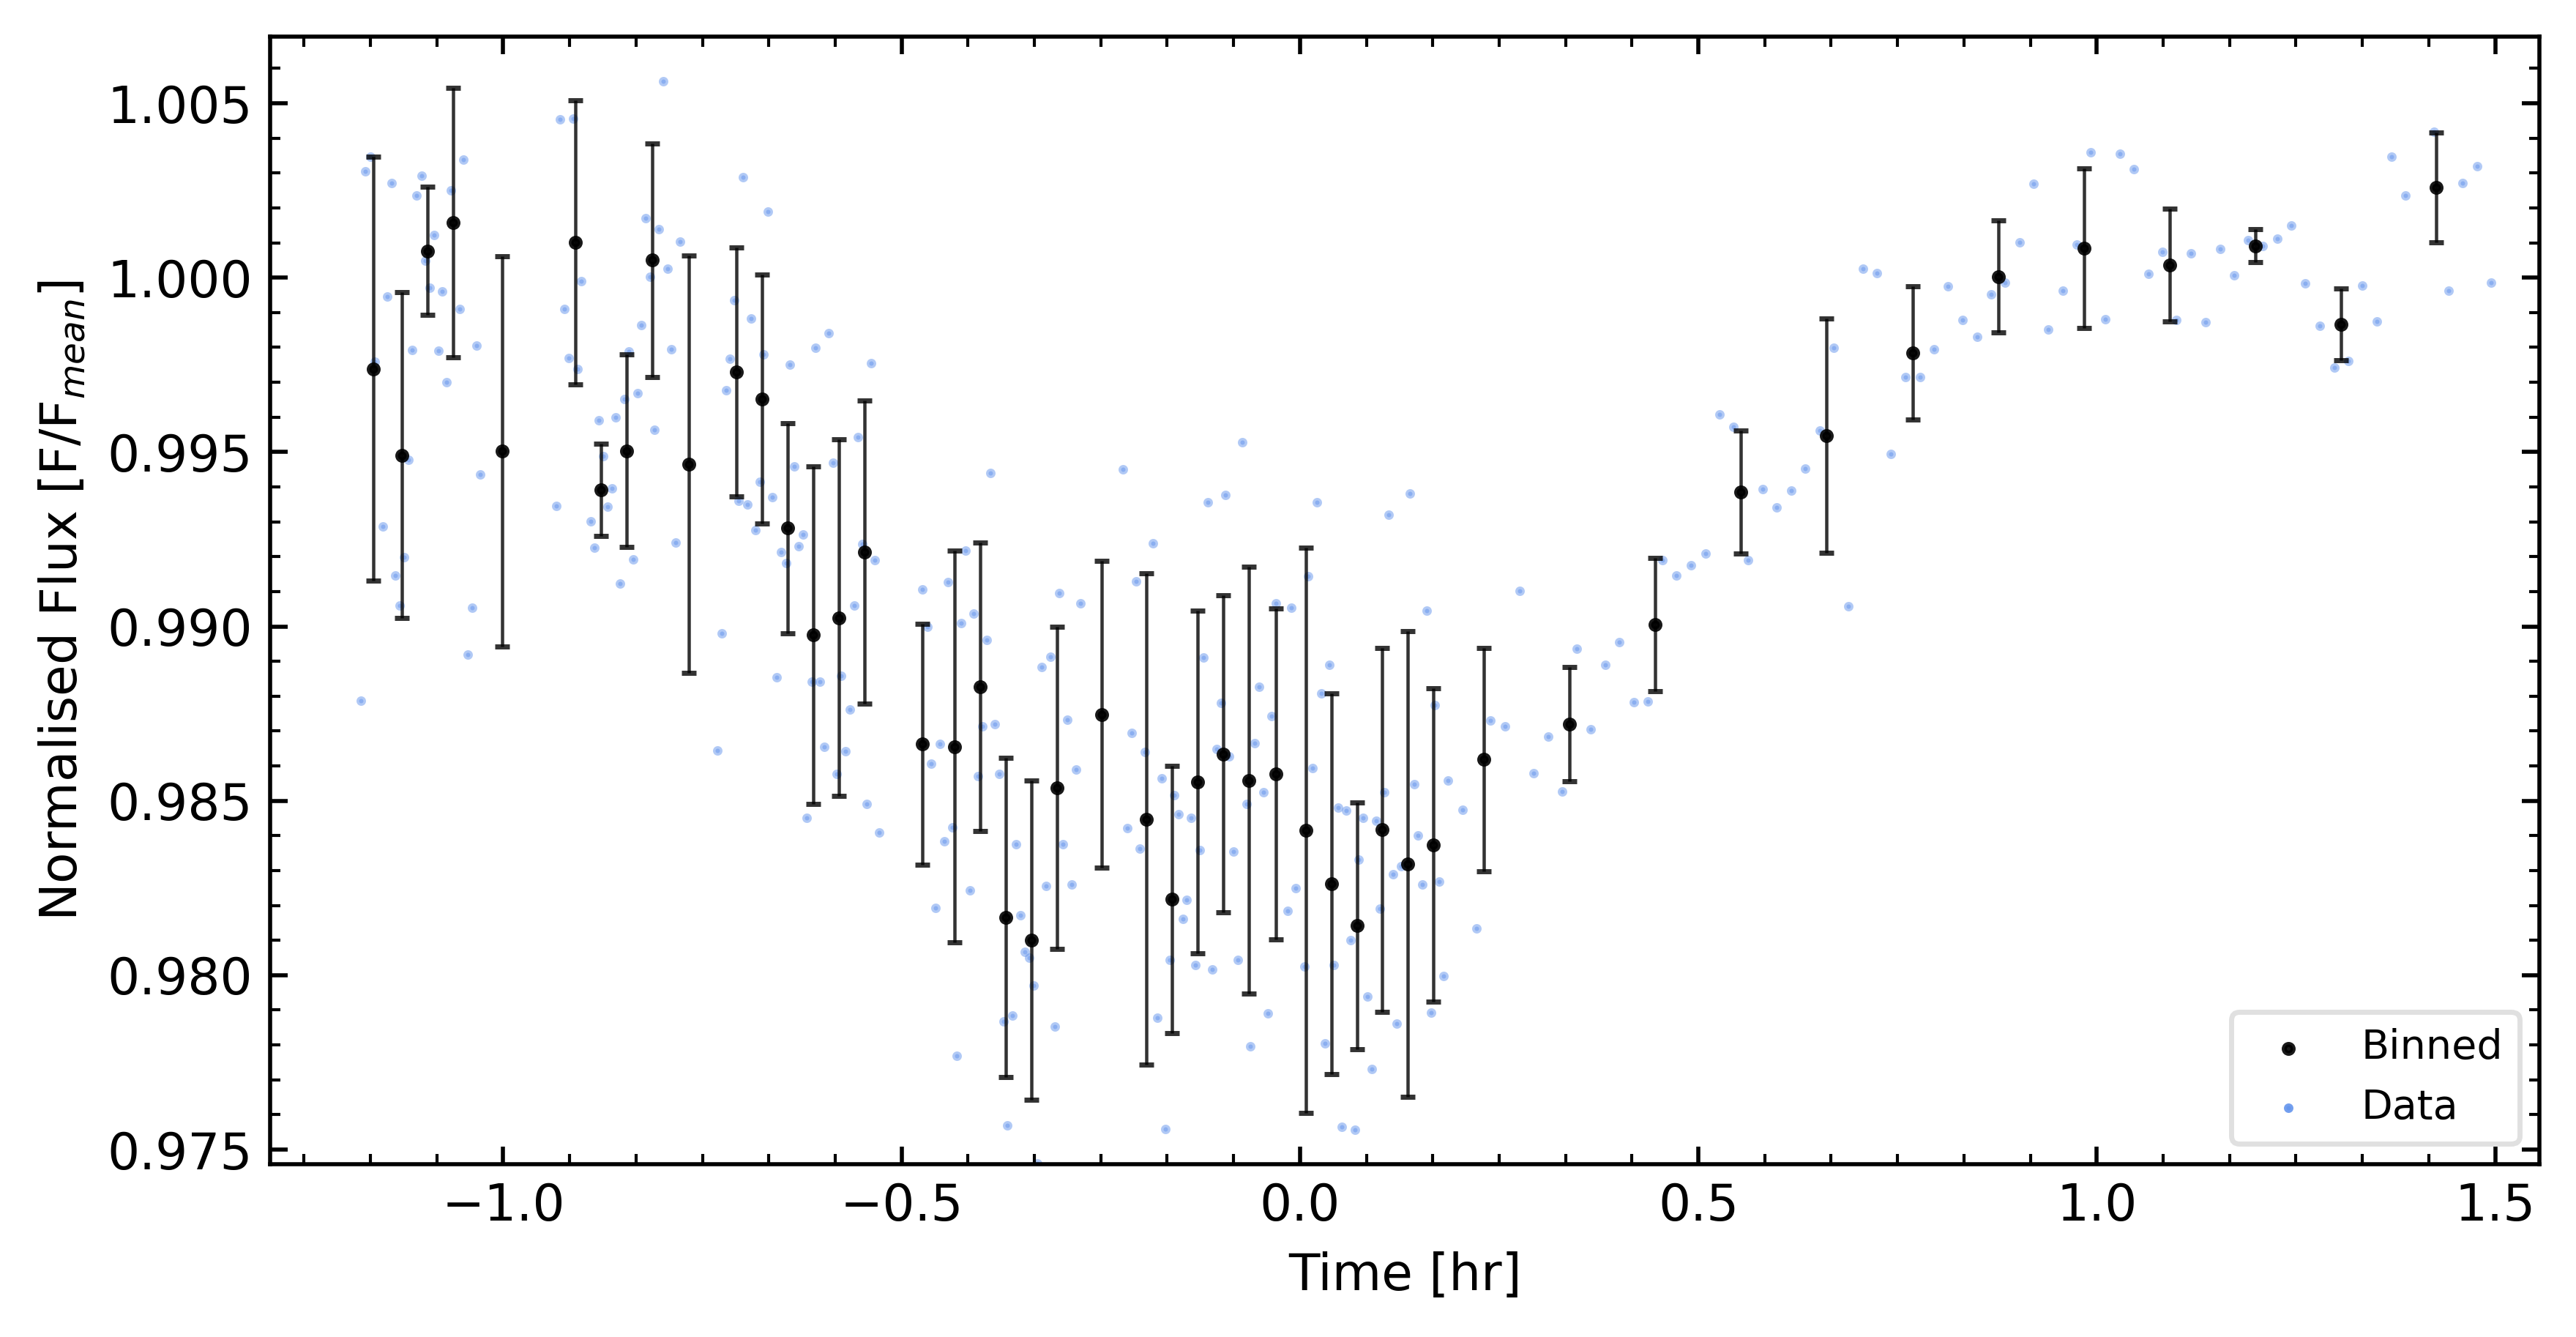

In [47]:
plt.figure(figsize=(8,4), dpi=500)

plt.scatter(avgDate, avgFlux, s=3, color='black', alpha=0.9, label='Binned', zorder=2)
plt.errorbar(avgDate, avgFlux, yerr=avgFluxErr, ecolor='black', elinewidth=0.65, alpha=0.8, capsize=1.5, linewidth=0, zorder=1)
xlims = plt.xlim()
ylims = plt.ylim()

plt.scatter(dateL, fluxL, s=3, marker='.', color='cornflowerblue', alpha=0.5, label='Data', zorder=0)
#plt.axhline(y=1, color='grey', linestyle = '--', alpha=0.4, linewidth=0.6)

plt.gca().tick_params(top=True, right=True, which='both', direction="in")
plt.gca().xaxis.set_minor_locator(mtick.AutoMinorLocator(6))
plt.gca().yaxis.set_minor_locator(mtick.AutoMinorLocator(5))
plt.xlim(xlims)
plt.ylim(ylims)
leg = plt.legend(loc=4, framealpha=0.6, fontsize=8)
leg.legendHandles[1].set_alpha(0.9)
plt.xlabel("Time [hr]")
plt.ylabel(r"Normalised Flux [F/F$_{mean}$]")
plt.show()

In [48]:
np.save('TrES_fluxList.npy', fluxL)
np.save('DateL.npy', dateL)
#np.save('ExpTime.npy', exptimeL)

# binning

print(stats.binned_statistic(fluxL[0:210], np.arange(len(mdates.date2num(dateL)[0:210])),
                       statistic = 'mean', bins = 15))



## Determining colours of TrES2


In [ ]:
#test data

std_star_data = {'Star Name' : ['PG2336_004B', 'GD391', 'SA 38_391', 'SA 20_297'], 'V mag': [12.43, 13.38, 8.58, 8.91],
                'Altitude': [33.9, 74.2, 51.1, 43.7], 'Exp.time': [30, 60, 10, 15], 
                 'Counts': [73980, 74820, 954928, 1047480], 'Counts_err': [2714, 2059, 8702, 9620]}

test_data = pd.DataFrame(std_star_data)

In [ ]:
#find airmass
test_data['airmass'] = 1/np.cos(np.pi/2 - (test_data['Altitude']*np.pi/180))

# first find counts per second
test_data['Count/s'] = test_data['Counts']/test_data['Exp.time']
test_data['Count_err/s'] = test_data['Counts_err']/test_data['Exp.time']

#instrumental magnitudes
test_data['inst mags'] = -2.5*np.log10(test_data['Count/s'])
test_data['inst mags err'] = test_data['Count_err/s']/test_data['Count/s']#*(-2.5) # aligns with test data if 2.5 left out

#difference of instrumental and true magnitudes
test_data['Vmag - inst mags'] = test_data['V mag'] - test_data['inst mags']
test_data['Vmag - inst mags err'] = test_data['inst mags err']

test_data

-0.26800459479786587 21.39276041173116


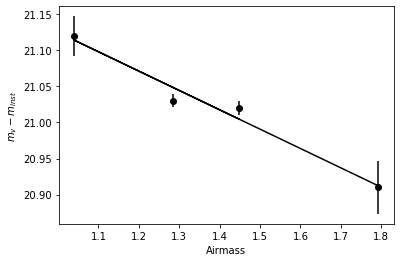

In [ ]:
# magnitude against airmass

#plt.scatter(test_data['airmass'], test_data['Vmag - inst mags'])
plt.errorbar(test_data['airmass'], test_data['Vmag - inst mags'], yerr=test_data['Vmag - inst mags err'], 
             c = 'black', fmt="o")
plt.xlabel('Airmass')
plt.ylabel('$m_v - m_{inst}$')

grad, y_int = np.polyfit(test_data['airmass'], test_data['Vmag - inst mags'], 1)
plt.plot(test_data['airmass'], (grad*test_data['airmass'])+y_int, c = 'black')

#y intercept = m-m_inst at airmass of 1
print(grad, y_int)

# grad = -k_lambda, y_int = m_zpt

#needs to be done for each filter seperatley as its wavelength dependent

#k_lambda will be bigger at shorter wavebands